# **Social Network Analysis: Understanding an Email Communication Network**

## **Context**

Email networks reveal how people communicate within organizations. By analyzing who emails whom, we can identify key individuals who play important roles in information flow and collaboration. This project uses the dataset email-Eu-core network (Paranjape, Benson, & Leskovec, 2014), an email network from a large European research institution, to find the most influential people and understand their structural and functional roles within the network. It utilizes social network analysis (SNA) to examine interaction patterns, centrality, and departmental connectivity.

## **Objectives**

- **Identify Key Individuals**: Find the most central people in the email network using centrality measures.
- **Understand Departmental Roles**: Determine if these individuals are concentrated in specific departments.
- **Analyze Cross-Department Communication**: Check if key individuals connect people within their own department or bridge multiple departments.

## **Data Source**

- The data source for this project is the **email-Eu-core network** dataset from the Stanford Large Network Dataset Collection Dataset (https://snap.stanford.edu/data/email-Eu-core.html).
- It contains 1,005 nodes, each representing an individual in a European research institution, and 25,571 directed edges representing emails sent between them.
- Each individual is also labeled with one of 42 department affiliations, allowing to analyze communication patterns both within and across departments.
- The dataset represents a core network extracted from the broader dataset, capturing only internal communications among members.


## **Network Analysis Process**

### **Step 1: Load and Prepare Data**
Task: Load the email communication edges and department membership labels. Remove self-loops.

In [ ]:
import pandas as pd
import networkx as nx

# Load edge list and remove self-loops
edges = pd.read_csv('email-Eu-core.txt', sep=' ', header=None, names=['source', 'target'])
edges = edges[edges['source'] != edges['target']]  # REMOVE SELF-LOOPS

# Load department labels
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ', header=None, names=['node', 'department'])

# Build directed graph
G = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.DiGraph())

# Add department info as node attribute
dept_dict = labels.set_index('node')['department'].to_dict()
nx.set_node_attributes(G, dept_dict, 'department')


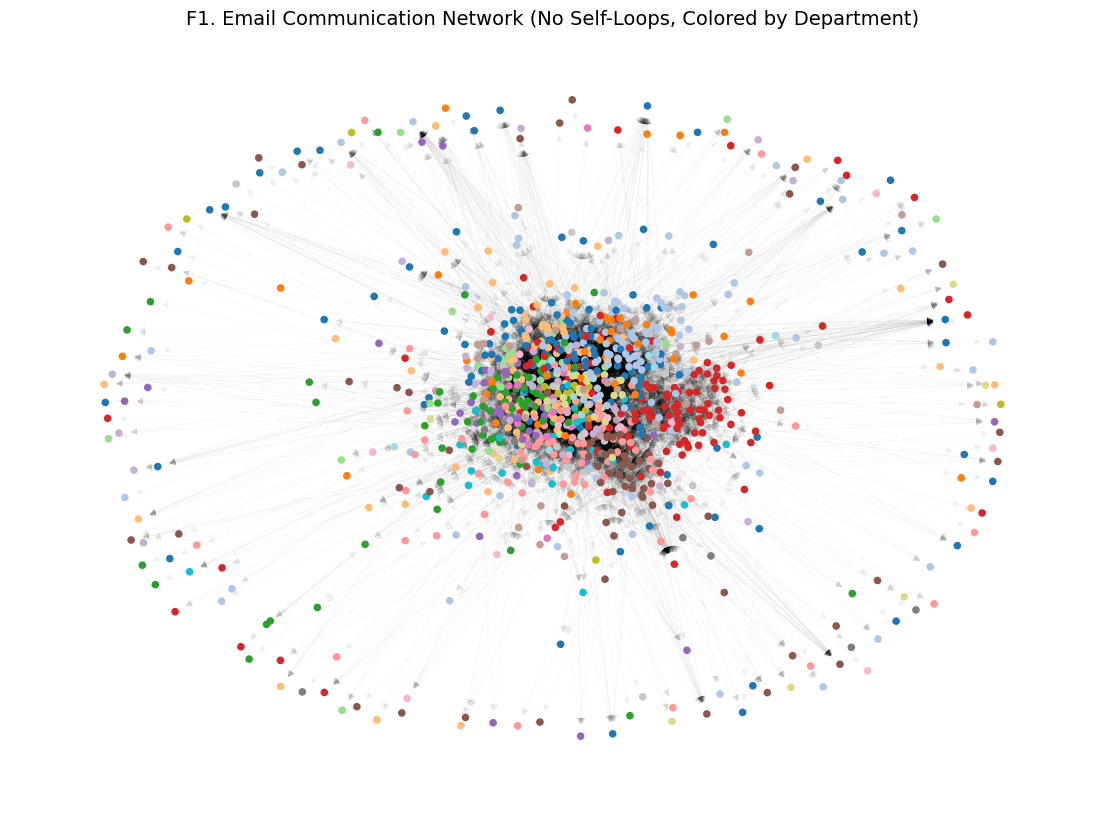

In [ ]:
# Visualization 1: Email Communication Network
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.15, seed=42)  # improved layout

node_colors = [G.nodes[n]['department'] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, cmap='tab20')
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3)

plt.title("F1. Email Communication Network (No Self-Loops, Colored by Department)", fontsize=14)
plt.axis('off')
plt.show()


Key Insights:

- Construct a directed graph with 1005 nodes and 25,571 edges.
- The dataset captures internal communications only, forming a highly connected organizational core.

### **Step 2: Compute Centrality Measures**
Task: Calculate degree, betweenness, closeness, and eigenvector centrality for each node.

In [ ]:
# Centrality calculations
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Combine into a DataFrame
centrality_df = pd.DataFrame({
    'degree': pd.Series(degree_centrality),
    'betweenness': pd.Series(betweenness_centrality),
    'closeness': pd.Series(closeness_centrality),
    'eigenvector': pd.Series(eigenvector_centrality),
    'department': pd.Series(dept_dict)
}).sort_values(by='degree', ascending=False)


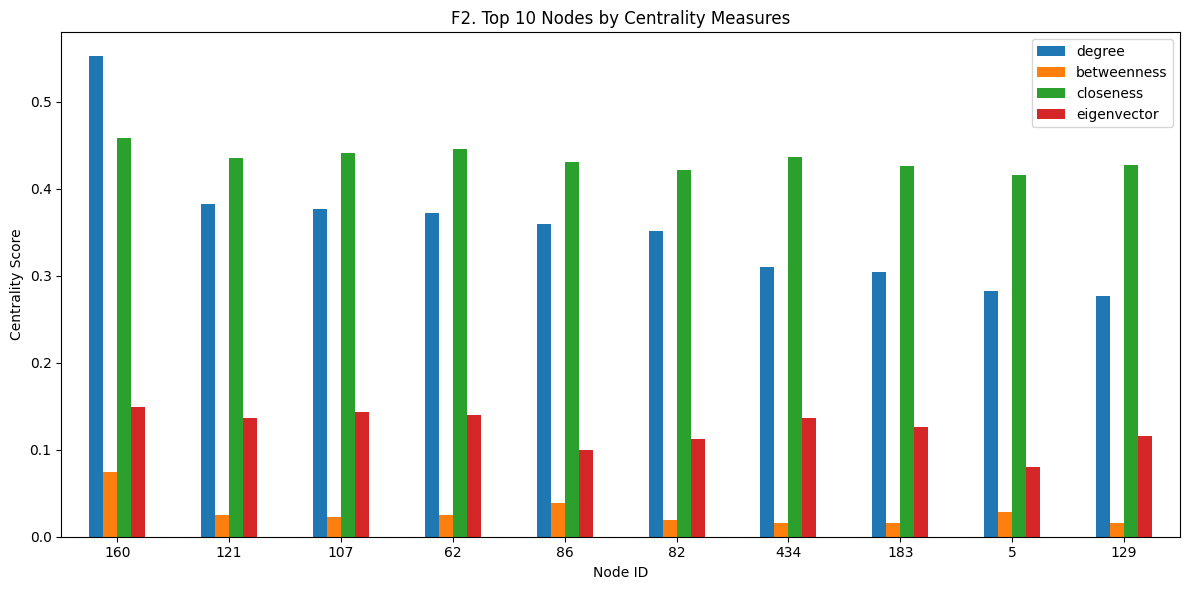

In [ ]:
# Visualization 2: Centrality Scores Bar Chart
top_10_df = centrality_df.head(10)

top_10_df[['degree', 'betweenness', 'closeness', 'eigenvector']].plot(kind='bar', figsize=(12, 6))
plt.title("F2. Top 10 Nodes by Centrality Measures")
plt.xlabel("Node ID")
plt.ylabel("Centrality Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Key Insights:

- A small subset of individuals exhibit very high centrality, suggesting a hub-like communication structure.

- Bar chart showing centrality scores of top 10 individuals across four metrics.

- Node 160 consistently ranks highest across multiple centrality measures, confirming their central role.


### **Step 3: Identify Key Individuals**
Task: Select top 10 individuals by centrality and visualize their connections.

In [ ]:
# Top 10 central nodes
top_n = 10
top_individuals = centrality_df.head(top_n)
print(top_individuals)


       degree  betweenness  closeness  eigenvector  department
160  0.552284     0.074931   0.458343     0.148984          36
121  0.382741     0.025488   0.435863     0.135922          36
107  0.376650     0.022710   0.441487     0.143490          36
62   0.372589     0.025466   0.445222     0.139899          36
86   0.359391     0.038892   0.431194     0.099446          36
82   0.351269     0.018940   0.421630     0.112103          36
434  0.310660     0.015351   0.436698     0.135932          34
183  0.304569     0.015538   0.426624     0.125834           4
5    0.282234     0.028036   0.415486     0.080088          25
129  0.277157     0.016176   0.427157     0.115270           4


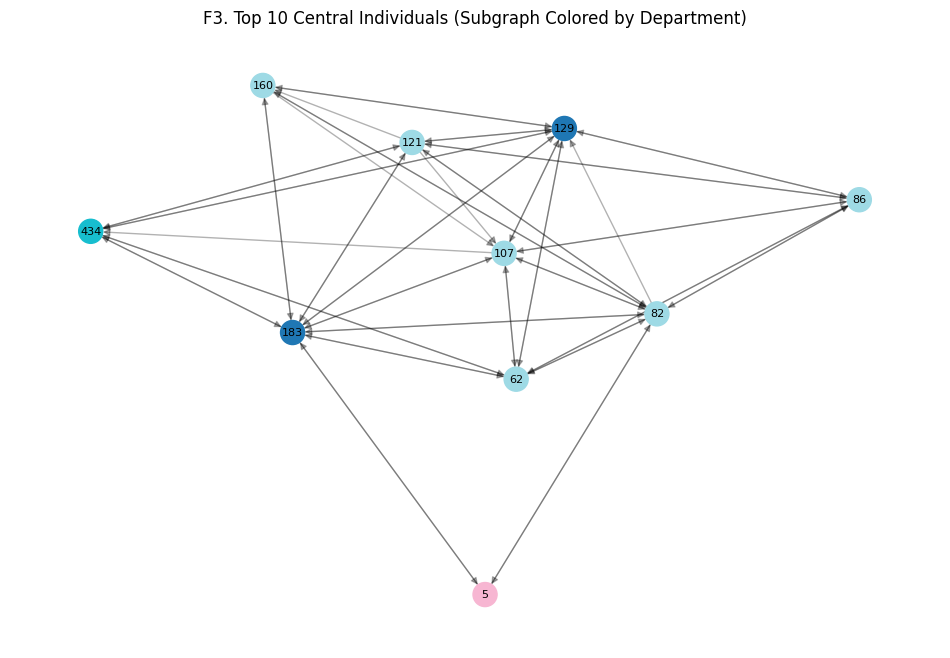

In [ ]:
# Visualization 3: Top 10 Central Individuals Subgraph
top_10_nodes = centrality_df.head(10).index
H = G.subgraph(top_10_nodes)
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(12, 8))
node_colors = [G.nodes[n]['department'] for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_color=node_colors, cmap='tab20', node_size=300)
nx.draw_networkx_edges(H, pos, alpha=0.3)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title("F3. Top 10 Central Individuals (Subgraph Colored by Department)")
plt.axis('off')
plt.show()


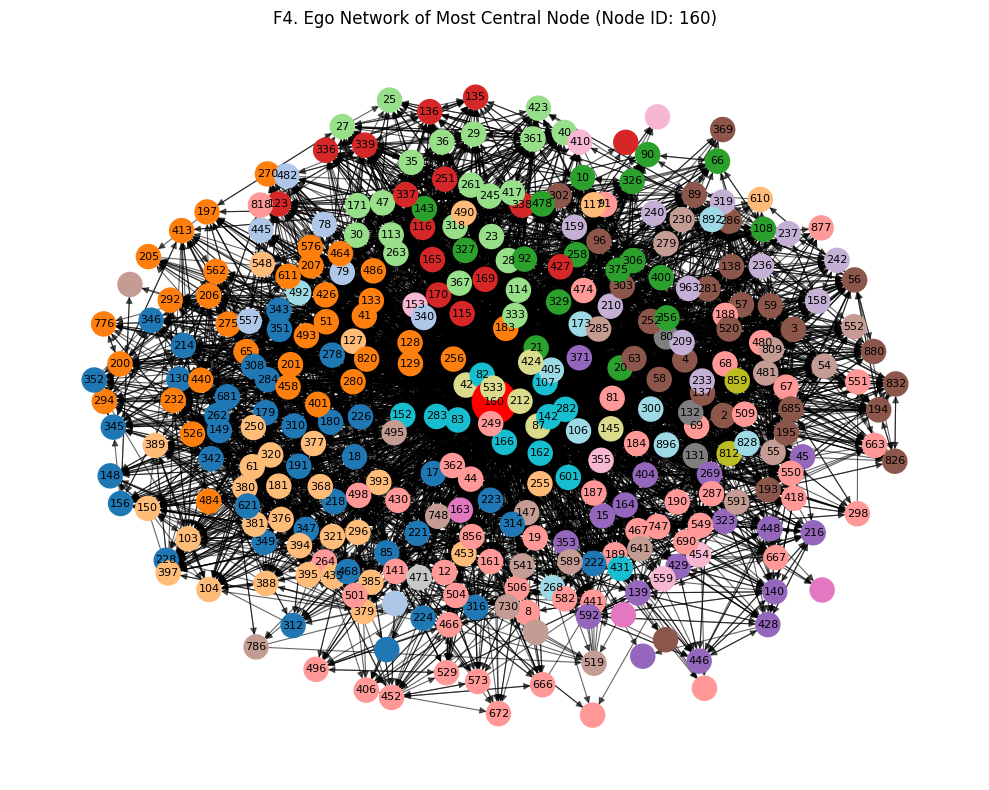

In [ ]:
# Visualization 4: Ego Network of the Most Central Individual
from matplotlib import colormaps

# Extract the most central node
most_central_node = centrality_df['degree'].idxmax()

# Create ego network (radius = 1)
ego = nx.ego_graph(G, most_central_node, radius=1)

# Compute layout
pos = nx.kamada_kawai_layout(ego)

# Normalize department IDs to colormap range
departments = [dept_dict[n] for n in ego.nodes() if n != most_central_node]
norm = plt.Normalize(min(departments), max(departments))
cmap = colormaps['tab20']

# Color map: red for ego, cmap for others
node_colors = [ 'red' if n == most_central_node else cmap(norm(dept_dict[n])) for n in ego.nodes() ]
node_sizes = [1000 if n == most_central_node else 300 for n in ego.nodes()]
labels = {n: str(n) for n in ego.nodes() if n == most_central_node or ego.degree(n) > 5}

# Plot
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(ego, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(ego, pos, arrows=True, arrowstyle='-|>', width=0.8, alpha=0.6)
nx.draw_networkx_labels(ego, pos, labels=labels, font_size=8)

plt.title(f"F4. Ego Network of Most Central Node (Node ID: {most_central_node})")
plt.axis('off')
plt.tight_layout()
plt.show()


Key Insights:

- Network visualization of most central nodes, colored by department.

- Highly central nodes form a dense subnetwork, indicating a strongly interconnected core group likely driving communication across the organization.

- Ego network showing immediate connections of the most central individual.

- Node 160 connects with individuals from diverse departments, reinforcing their role as a key cross-departmental connector.

### **Step 4: Departmental Distribution Analysis**
Task: Analyze the departments of top-ranking individuals.

In [ ]:
# Count how many top individuals come from each department
top_depts = top_individuals['department'].value_counts()
print(top_depts)


department
36    6
4     2
34    1
25    1
Name: count, dtype: int64


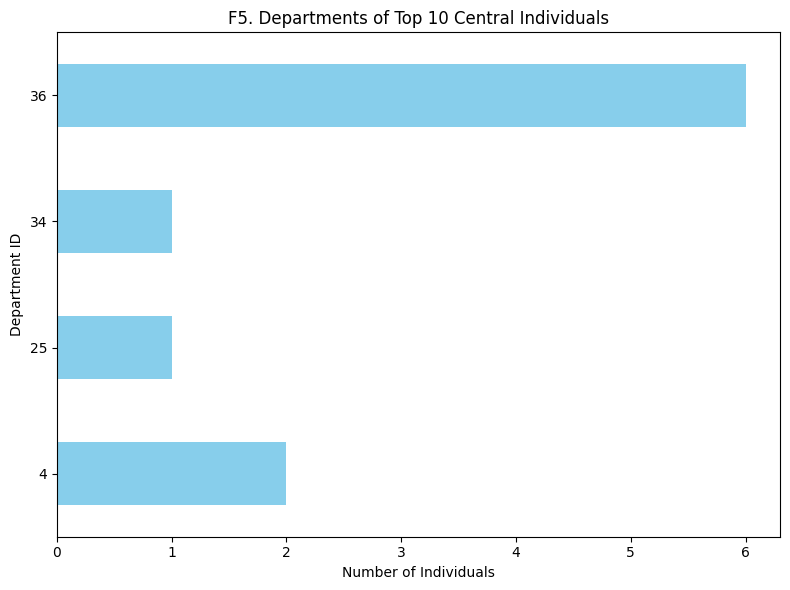

In [ ]:
# Visualization 5: Departmental Distribution of Top Central Nodes
dept_counts = top_10_df['department'].value_counts().sort_index()
dept_counts.plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title("F5. Departments of Top 10 Central Individuals")
plt.xlabel("Number of Individuals")
plt.ylabel("Department ID")
plt.tight_layout()
plt.show()


Key Insights:
- Bar chart showing the number of top central individuals per department.

- A few departments dominate central communication roles, while others are underrepresented—indicating hierarchical communication structures.

### **Step 5: Cross-Department Communication Analysis**
Task: Identify cross-department email edges and generate a communication heatmap.

In [ ]:
def cross_department_edges(G):
    cross_edges = []
    for u, v in G.edges():
        if G.nodes[u]['department'] != G.nodes[v]['department']:
            cross_edges.append((u, v))
    return cross_edges

# Get all cross-department emails
cross_edges = cross_department_edges(G)
cross_edge_df = pd.DataFrame(cross_edges, columns=['source', 'target'])

# Count how many cross-department emails each sender sent
cross_counts = cross_edge_df['source'].value_counts()

# Make a true copy of the top central individuals to avoid SettingWithCopyWarning
top_n = 10
top_individuals = centrality_df.head(top_n).copy()

# Add a new column showing how many cross-department emails each top person sent
top_individuals['cross_dept_emails_sent'] = top_individuals.index.map(cross_counts).fillna(0).astype(int)

# Display results
print(top_individuals[['degree', 'betweenness', 'closeness', 'eigenvector', 'department', 'cross_dept_emails_sent']])


       degree  betweenness  closeness  eigenvector  department  \
160  0.552284     0.074931   0.458343     0.148984          36   
121  0.382741     0.025488   0.435863     0.135922          36   
107  0.376650     0.022710   0.441487     0.143490          36   
62   0.372589     0.025466   0.445222     0.139899          36   
86   0.359391     0.038892   0.431194     0.099446          36   
82   0.351269     0.018940   0.421630     0.112103          36   
434  0.310660     0.015351   0.436698     0.135932          34   
183  0.304569     0.015538   0.426624     0.125834           4   
5    0.282234     0.028036   0.415486     0.080088          25   
129  0.277157     0.016176   0.427157     0.115270           4   

     cross_dept_emails_sent  
160                     325  
121                     204  
107                     191  
62                      179  
86                      187  
82                      207  
434                     148  
183                     120  
5  

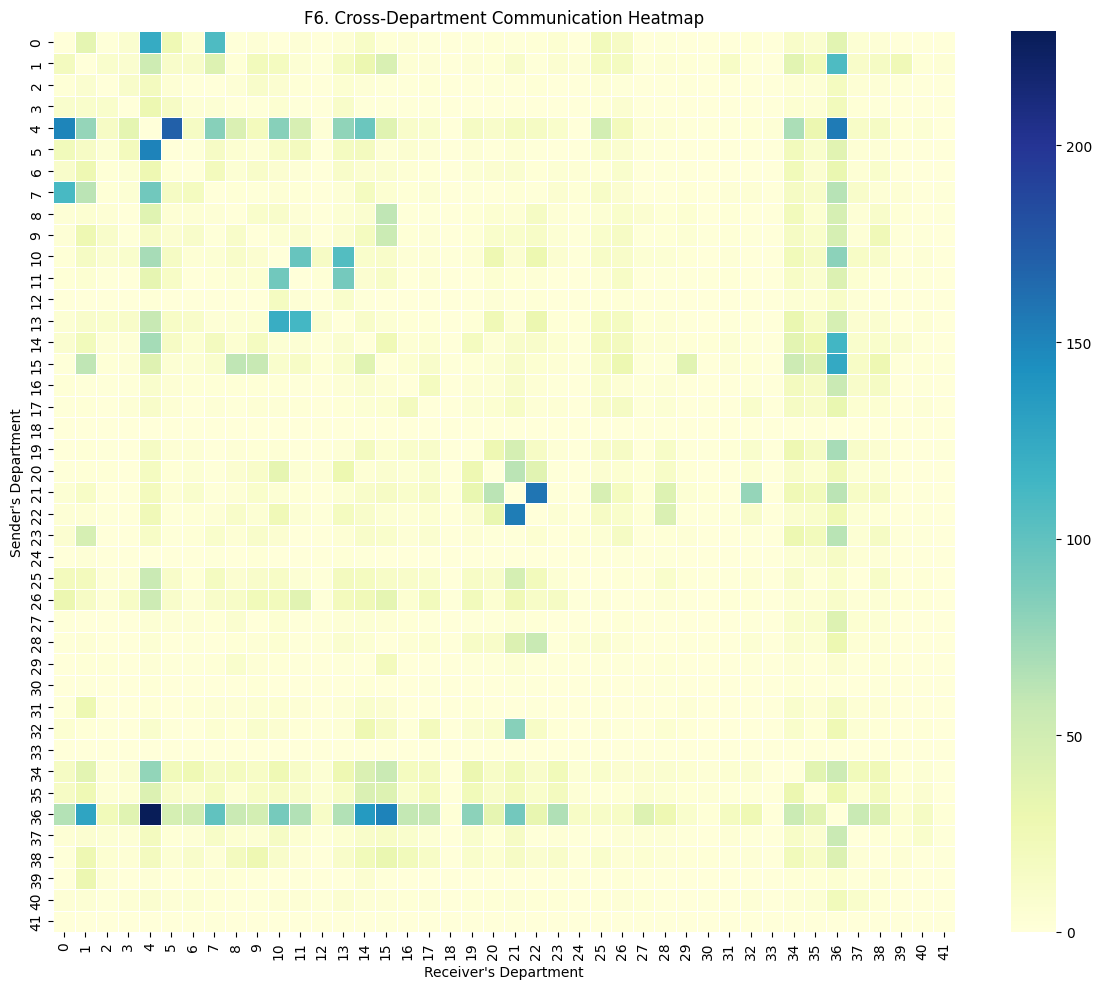

In [ ]:
# Visualization 6: Cross-Department Communication Heatmap
import seaborn as sns

# Build matrix of sender-department to receiver-department
cross_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['department'] != G.nodes[v]['department']]
matrix = pd.DataFrame(0, index=range(42), columns=range(42))  # 42 departments

for u, v in cross_edges:
    s_dept = G.nodes[u]['department']
    r_dept = G.nodes[v]['department']
    matrix.loc[s_dept, r_dept] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap='YlGnBu', linewidths=0.5)
plt.title("F6. Cross-Department Communication Heatmap")
plt.xlabel("Receiver's Department")
plt.ylabel("Sender's Department")
plt.tight_layout()
plt.show()


Key Insights:
- Heatmap showing volume of email exchanges between departments.

- Certain departments (e.g., 21, 14) act as communication bridges across the organization, while others communicate mostly internally.

## **Findings**

- Node 160 is the most central individual across all centrality measures.
- A small group of individuals forms a dense communication core.
- Departments 36 and 4 dominate central roles; others are underrepresented.
- Some departments (e.g., 36, 4) act as bridges, while others are siloed.
- Node 160's ego network shows strong cross-department connectivity.
- The network displays a core-periphery structure, suggesting centralization and potential bottlenecks.

## **Limitations**

- The dataset includes only email metadata — no access to message content or context.
- Temporal dynamics are not captured, so changes over time can't be analyzed.
- Other communication modes (e.g., meetings, chats) are not included.
- There is no metadata on individual roles (e.g., admin vs. researcher).
- Different centrality measures may highlight different individuals, requiring careful interpretation.

## **Implications**

- Some individuals or departments may be isolated from broader communication flows.
- Highly central individuals may be overburdened, posing a risk of bottlenecks.
- Findings offer insights for enhancing cross-department collaboration.
- Results can support internal communication improvements and organizational equity.